In [1]:
# -*- coding:utf-8 -*-
# 首先加载必用的库
import tensorflow as tf
import numpy as np
# import gensim  用来加载预训练word vector
from gensim.models import KeyedVectors
import jieba
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings("ignore")

C:\SoftWare\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# 使用gensim加载预训练中文分词embedding, 有可能需要等待1-2分钟
cn_model = KeyedVectors.load_word2vec_format('../embeddings/sgns.zhihu.bigram',binary=False, unicode_errors="ignore")

W0708 12:20:02.721931  7060 utils_any2vec.py:185] duplicate word '--------------------------------------------------------------------------------------------------' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0708 12:20:05.682164  7060 utils_any2vec.py:185] duplicate word '--------------------------------------------------------------------------------------------------' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0708 12:20:11.631563  7060 utils_any2vec.py:185] duplicate word '--------------------------------------------------------------------------------------------------' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0708 12:20:15.867930  7060 utils_any2vec.py:185] duplicate word '--------------------------------------------------------------------------------------------------' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0708 12:20:17.276091  7060 utils_any2vec.py:185] duplicate word '----------------------------------

W0708 12:20:21.466251  7060 utils_any2vec.py:185] duplicate word '--------------------------------------------------------------------------------------------------' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0708 12:20:21.466251  7060 utils_any2vec.py:185] duplicate word '..................................................................................................' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0708 12:20:21.466251  7060 utils_any2vec.py:185] duplicate word '--------------------------------------------------------------------------------------------------' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0708 12:20:21.481873  7060 utils_any2vec.py:185] duplicate word '..................................................................................................' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0708 12:20:21.481873  7060 utils_any2vec.py:185] duplicate word '----------------------------------

In [3]:
# 由此可见每一个词都对应一个长度为300的向量
embedding_dim = cn_model['山东大学'].shape[0]
embedding_dim

300

In [4]:
# 获得样本的索引
import pandas as pd

data_neg = pd.read_excel('../data/neg.xlsx')
data_pos = pd.read_excel('../data/pos.xls')

print('样本总数：'+str(len(data_pos) + len(data_neg)))

样本总数：7909


In [5]:
data_pos.head(1)

,做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持一颗年轻的心。我想，这是他能很好的和孩子沟通的一个重要因素。读刘墉的文章，总能让我看到一个快乐的平易近人的父亲，他始终站在和孩子同样的高度，给孩子创造着一个充满爱和自由的生活环境。很喜欢刘墉在字里行间流露出的做父母的那种小狡黠，让人总是忍俊不禁，父母和子女之间有时候也是一种战斗，武力争斗过于低级了，智力较量才更有趣味。所以，做父母的得加把劲了，老思想老观念注定会一败涂地，生命不息，学习不止。家庭教育，真的是乐在其中。
0,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...


In [6]:
# 将所有的评价内容放置到一个list里
train_texts_orig = []
# 文本所对应的labels，也就是标记
train_target = []

for indexs in data_neg.index:
    train_texts_orig.append(data_neg.loc[indexs].values[1])
    train_target.append(data_neg.loc[indexs].values[0])

In [7]:
print(len(train_texts_orig))
# print(train_target)
train_texts_orig[3824]

3825


'明明在携程上用信用卡担保定了房，入住时居然前台说没有此信息，而且房间已经住满了，打电话到携程投诉，说是酒店预订部与前台没沟通好，折腾了半天，非常气人!'

In [8]:
for indexs in data_pos.index:
    train_texts_orig.append(data_pos.loc[indexs].values[0])
    train_target.append("0")

In [9]:
print(len(train_texts_orig))
# print(train_target)
train_texts_orig[3856]

7909


'最真实与实用的白领成长故事，也是目前为止我所读过的最深刻的白领生活工作的总结。看了不但受益匪浅，而且觉得过瘾、振奋，为中国有这样优秀的打工人而自豪。看了确实有：“...让我回忆最多的，却不是人生旅途里这些成功的瞬间，而是那些刻骨铭心的失败或挫折...”它展示地是一个真实与真诚的人，一个真心与你分享如何才能成功，而不是一个天才的故事、打工的神仙。强烈推荐！'

In [10]:
# 使用tensorflow的keras接口来建模
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [11]:
# 进行分词和tokenize
# train_tokens是一个长长的list，其中含有7909个小list，对应每一条评价
train_tokens = []
for text in train_texts_orig:
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（） ]+", "",text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)

Building prefix dict from the default dictionary ...
I0708 12:20:23.766945  7060 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache F:\AppData\summer\Temp\jieba.cache
I0708 12:20:23.769938  7060 __init__.py:131] Loading model from cache F:\AppData\summer\Temp\jieba.cache
Loading model cost 0.856 seconds.
I0708 12:20:24.624858  7060 __init__.py:163] Loading model cost 0.856 seconds.
Prefix dict has been built succesfully.
I0708 12:20:24.625855  7060 __init__.py:164] Prefix dict has been built succesfully.


In [12]:
# 获得所有tokens的长度
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)
print("num_tokens:",num_tokens)
# print(train_tokens)
len(train_tokens)
print(len(num_tokens))

num_tokens: [76 34 33 ... 39 16 19]
7909


In [13]:
# 平均tokens的长度
print(np.mean(num_tokens))

70.6515362245543


In [14]:
# 最长的评价tokens的长度
print(np.max(num_tokens))

1540


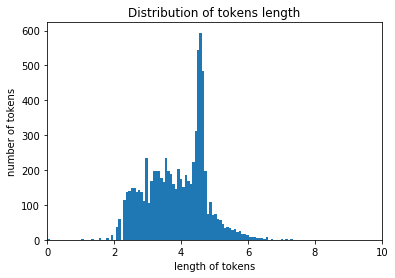

In [15]:
plt.hist(np.log(num_tokens), bins = 100)
plt.xlim((0,10))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [16]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

223

In [17]:
# 取tokens的长度为223时，大约96%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)

0.9675053736249842

In [18]:
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

In [19]:
cn_model.index2word[120]

'再'

In [20]:
train_tokens[0]

[59,
 69,
 0,
 154664,
 1,
 2010,
 473,
 16,
 1,
 57,
 2537,
 1,
 11119,
 649,
 1305,
 144,
 5,
 6,
 1,
 19945,
 869,
 90,
 86,
 197235,
 126,
 155,
 39283,
 22,
 18,
 711,
 3,
 40,
 155,
 574,
 1,
 87,
 1946,
 8,
 34,
 655,
 1,
 644,
 4253,
 18,
 38,
 16,
 143,
 13176,
 78,
 49,
 0,
 51,
 27,
 135,
 29865,
 391,
 18,
 711,
 3,
 91,
 51,
 202,
 39,
 11119,
 4862,
 122,
 62,
 441,
 1,
 188009,
 691,
 613,
 4,
 374,
 7294,
 79]

In [21]:
reverse = reverse_tokens(train_tokens[0])
reverse

'做为 声名在外的流行书说的还是广州的外企按道理应该和我的生存环境差不多啊但是一看之下才发现相去甚远这也就算了还发现其中的很多规则有很强的企业个性也就说只是个例而不是 给我们这些老油条看看也就算了如果给那些对外企向往或者想了解的freshman来看实在是容易误导他们'

In [22]:
# 只使用前50000个词
num_words = 100000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')
embedding_matrix

array([[-0.801784, -0.16534 ,  0.030508, ...,  0.106525,  0.553436,
         0.43665 ],
       [-0.651747,  0.53597 ,  0.340271, ...,  0.805399,  0.104593,
         0.193694],
       [-0.412321,  0.228261,  0.207114, ...,  0.808777,  0.056751,
         0.452374],
       ...,
       [ 0.399163, -0.361203, -0.155123, ..., -0.026335,  0.078385,
         0.042472],
       [-0.198514, -0.436683,  0.416873, ..., -0.104323,  0.072952,
         0.390674],
       [ 0.071814,  0.090673,  0.014804, ..., -0.278364, -0.241816,
        -0.227115]], dtype=float32)

In [24]:
# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
np.sum(cn_model[cn_model.index2word[30]] == embedding_matrix[30])

300

In [25]:
# embedding_matrix的维度，
# 这个维度为keras的要求，后续会在模型中用到
print("embedding_matrix.shape", embedding_matrix.shape)

embedding_matrix.shape (100000, 300)


In [26]:
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens, padding='pre', truncating='pre')
train_pad[33]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [27]:
# 超出五万个词向量的词用0代替
train_pad[train_pad >= num_words] = 0

In [28]:
# 可见padding之后前面的tokens全变成0，文本在最后面
print("train_pad[33]", train_pad[33])

train_pad[33] [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0 

In [29]:
# 准备target向量
train_target = np.array(train_target)
train_target

array(['1', '1', '1', ..., '0', '0', '0'], dtype='<U21')

In [30]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split

In [31]:
from tensorflow.python.keras.utils import to_categorical
""" one-hot处理标签 """
train_target = to_categorical(train_target)

In [32]:
train_target.shape

(7909, 10)

In [33]:
# 90%的样本用来训练，剩余10%用来测试
X_train, X_test, y_train, y_test = train_test_split(train_pad, train_target, test_size=0.1, random_state=1000)

In [34]:
# def vectorize_sequences(squences, dimension=10):
#     """
#     @函数功能:将序列向量化，初始化全0的序列，在单词索引对应的位置上置1
#     """
#     resluts = np.zeros((len(squences), dimension))
#     for i, sequence in enumerate(squences):
#         resluts[i, sequence] = 1
#     return resluts

# X_train = vectorize_sequences(X_train)
# X_test = vectorize_sequences(X_test)

In [35]:
# 查看训练样本，确认无误
print(reverse_tokens(X_train[30]))
print('class: ', y_train[30])

                                                                                                                                                                                              很好的酒店很喜欢房间很干净很漂亮从房间的窗口看出去超美的在市中心区域出行也非常的方便有机会一定会再住的
class:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [36]:
# 用LSTM对样本进行分类
model = Sequential()

In [37]:
# 模型第一层为embedding
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_tokens, trainable=False))

# model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
# model.add(LSTM(units=16, return_sequences=False))
model.add(LSTM(units=32, return_sequences=False))

model.add(Dense(10, activation='softmax'))

W0708 12:20:32.123103  7060 deprecation.py:506] From C:\SoftWare\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0708 12:20:32.640611  7060 deprecation.py:506] From C:\SoftWare\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [38]:
# 我们使用adam以0.001的learning rate进行优化
optimizer = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])

In [39]:
# 我们来看一下模型的结构，一共90k左右可训练的变量
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 223, 300)          30000000  
_________________________________________________________________
lstm (LSTM)                  (None, 32)                42624     
_________________________________________________________________
dense (Dense)                (None, 10)                330       
Total params: 30,042,954
Trainable params: 42,954
Non-trainable params: 30,000,000
_________________________________________________________________


In [40]:
# 建立一个权重的存储点
path_checkpoint = 'sentiment_checkpoint_Class10_V1.0.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)

# 尝试加载已训练模型
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

Unable to open file (unable to open file: name = 'sentiment_checkpoint_Class10_V1.0.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [41]:
# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [42]:
# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-8, patience=0, verbose=1)

In [43]:
# 定义callback函数
callbacks = [
    earlystopping,
    checkpoint,
    lr_reduction
]

In [44]:
# 开始训练
history = model.fit(X_train, y_train,
          validation_split=0.1,
          epochs=20,
          batch_size=128,
          callbacks=callbacks)

W0708 12:20:33.130766  7060 deprecation.py:323] From C:\SoftWare\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6406 samples, validate on 712 samples
Epoch 1/20
6400/6406 [============================>.] - ETA: 0s - loss: 1.5640 - acc: 0.5094
Epoch 00001: val_loss improved from inf to 1.25421, saving model to sentiment_checkpoint_Class10_V1.0.keras
6406/6406 [==============================] - 17s 3ms/sample - loss: 1.5637 - acc: 0.5092 - val_loss: 1.2542 - val_acc: 0.5857
Epoch 2/20
6400/6406 [============================>.] - ETA: 0s - loss: 1.1014 - acc: 0.6442
Epoch 00002: val_loss improved from 1.25421 to 0.93306, saving model to sentiment_checkpoint_Class10_V1.0.keras
6406/6406 [==============================] - 15s 2ms/sample - loss: 1.1021 - acc: 0.6441 - val_loss: 0.9331 - val_acc: 0.6728
Epoch 3/20
6400/6406 [============================>.] - ETA: 0s - loss: 0.9073 - acc: 0.6945
Epoch 00003: val_loss improved from 0.93306 to 0.81526, saving model to sentiment_checkpoint_Class10_V1.0.keras
6406/6406 [==============================] - 15s 2ms/sample - loss: 0.9071 - acc: 0.6945 -

In [46]:
history.history

{'loss': [1.475465745078077,
  1.0321501104525763,
  0.9788035252784291,
  0.877032354776464,
  0.8218140274221138,
  0.7594383644324484,
  0.7160257967633826,
  0.6894514513618679,
  0.6775672882934901,
  0.6701676432802794,
  0.660525131822935,
  0.6540994528603115,
  0.645686572928783,
  0.639702994135667,
  0.6360668492920132,
  0.6351471176714664,
  0.6350428458213657,
  0.6350340524242328,
  0.6350335110882614],
 'acc': [0.55775833,
  0.66359663,
  0.67311895,
  0.7129254,
  0.71557915,
  0.7343116,
  0.74898535,
  0.7597565,
  0.76319075,
  0.7642835,
  0.77005935,
  0.76724946,
  0.77958167,
  0.78067434,
  0.7817671,
  0.7819232,
  0.7820793,
  0.7820793,
  0.7820793],
 'val_loss': [1.0712110072039487,
  1.0128524410590698,
  0.8793537395723751,
  0.8382323498136541,
  0.783096975155091,
  0.8094800027568688,
  0.7189175352621614,
  0.7082371684942352,
  0.7057914760675323,
  0.6998210964577921,
  0.6958600577343715,
  0.6927456795499566,
  0.697834849357605,
  0.6906361506226

In [45]:
def show_acc(history):
    """ 绘制精度曲线 """
    plt.clf()
    history_dict = history.history
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = range(1, len(val_acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()

    plt.show()

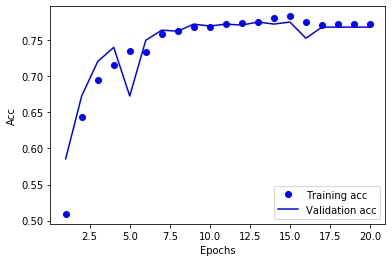

In [46]:
""" show result """
show_acc(history)

In [47]:
y_test.shape

(791, 10)

In [48]:

#开始测试
result = model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

791/791 [==============================] - 1s 1ms/sample - loss: 0.7750 - acc: 0.7345
Accuracy:73.45%


In [62]:
def predict_sentiment(text):
    print(text)
    # 去标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
            if cut_list[i] >= 50000:
                cut_list[i] = 0
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens, padding='pre', truncating='pre')
    # 预测
    result = model.predict(x=tokens_pad)
    num = np.argmax(result)
    if num == 0:
        print('是一例正面评价', 'output=%.2f' % result[0][num])
    elif num >= 1 and num <= 9:
        print('负面评价  %d' % d, 'output=%.2f' % result[0][num])
    else:
        print('error!!!')

In [61]:
num = 2
if num == 2:
    print("22222222")
else:
    print("55555555")

22222222


In [63]:
test_list = [
    '酒店设施不是新的，服务态度很不好',
    '酒店卫生条件非常不好',
    '床铺非常舒适',
    '房间很凉，不给开暖气',
    '房间很凉爽，空调冷气很足',
    '酒店环境不好，住宿体验很不好',
    '房间隔音不到位' ,
    '晚上回来发现没有打扫卫生',
    '因为过节所以要我临时加钱，比团购的价格贵'
]
for text in test_list:
    predict_sentiment(text)

酒店设施不是新的，服务态度很不好
负面评价  2 output=0.17
酒店卫生条件非常不好
负面评价  6 output=0.33
床铺非常舒适
是一例正面评价 output=0.65
房间很凉，不给开暖气
负面评价  7 output=0.39
房间很凉爽，空调冷气很足
是一例正面评价 output=0.69
酒店环境不好，住宿体验很不好
负面评价  6 output=0.40
房间隔音不到位
负面评价  7 output=0.40
晚上回来发现没有打扫卫生
负面评价  7 output=0.28
因为过节所以要我临时加钱，比团购的价格贵
负面评价  7 output=0.38


In [65]:
text = "酒店太脏且设施陈旧，不符合三星标准，前台价格低于携程价格"
predict_sentiment(text)

酒店太脏且设施陈旧，不符合三星标准，前台价格低于携程价格
负面评价  7 output=0.44


In [39]:
y_pred = model.predict(X_test)
# print(y_pred)
y_pred = y_pred.T[0]
y_pred = [1 if p >= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

y_actual = np.array(y_test)

In [45]:
# 找出错误分类的索引
misclassified = np.where( y_pred != y_actual )[0]

# 输出所有错误分类的索引
len(misclassified)

1

In [48]:
misclassified[0]

0

In [49]:
# 我们来找出错误分类的样本看看
idx = misclassified[0]
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

                                                                                                                                                                                                                   比较适合国内客一楼餐厅风格上有点南洋的味道
预测的分类 1
实际的分类 1


In [ ]:
idx = 1
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])